In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import sys
import pdb
import matplotlib.pyplot as plt
from glob import glob
import pickle
from pyuoi.linear_model.var import VAR
from tqdm import tqdm
import pandas as pd
from neurosim.models.var import VAR as VARss
from neurosim.models.var import form_companion
from copy import deepcopy
#from dstableFGM import dstable_descent

In [4]:
sys.path.append('../..')
from loaders import load_sabes
from subspaces import estimate_autocorrelation
from utils import apply_df_filters

### Score (FCCA/Variance) vs. dimension, Indy

In [5]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
sabes_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [16]:
data_files = np.unique(sabes_df['data_file'].values)
folds = np.arange(5)
dimreduc_methods = dimreduc_methods = ['PCA', 'LQGCAtrace']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}, {'T':3, 'causal_weights':(1, 1), 'n_init':5}]
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}, {'T':3, 'loss_type':'logdet', 'n_init':5},
                       {'T':3, 'loss_type':'additive', 'n_init':5}]

dimvals = np.unique(sabes_df['dim'].values)

# Pick one
decoder_arg = sabes_df.iloc[0]['decoder_args']
df = apply_df_filters(sabes_df, decoder_args=decoder_arg)

scores = np.zeros((data_files.size, len(dimreduc_methods), folds.size, dimvals.size))

for i, data_file in enumerate(data_files):
    for j, dr_method in enumerate(dimreduc_methods):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            
                if 'KCA' in dr_method:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method='KCA', fold_idx=fold, dim=dimval)
                    # Further filter by dimreduc_args
                    if dr_method == 'KCAfwd':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[0])
                    elif dr_method == 'KCArev':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[1])
                    elif dr_method == 'KCAeven':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[2])
                elif 'LQGCA' in dr_method:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval)
                    # Further filter by dimreduc_args
                    if dr_method == 'LQGCAtrace':
                        df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[0])
                    elif dr_method == 'LQGCAfro':
                        df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[1])
                else:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method=dr_method, fold_idx=fold, dim=dimval)

                if dr_method == 'PCA':
                    scores[i, j, f, d] = np.sum(df_.iloc[0]['score'][0:d])/np.sum(df_.iloc[0]['score'])
                else:
                    scores[i, j, f, d] = df_.iloc[0]['score'].numpy()

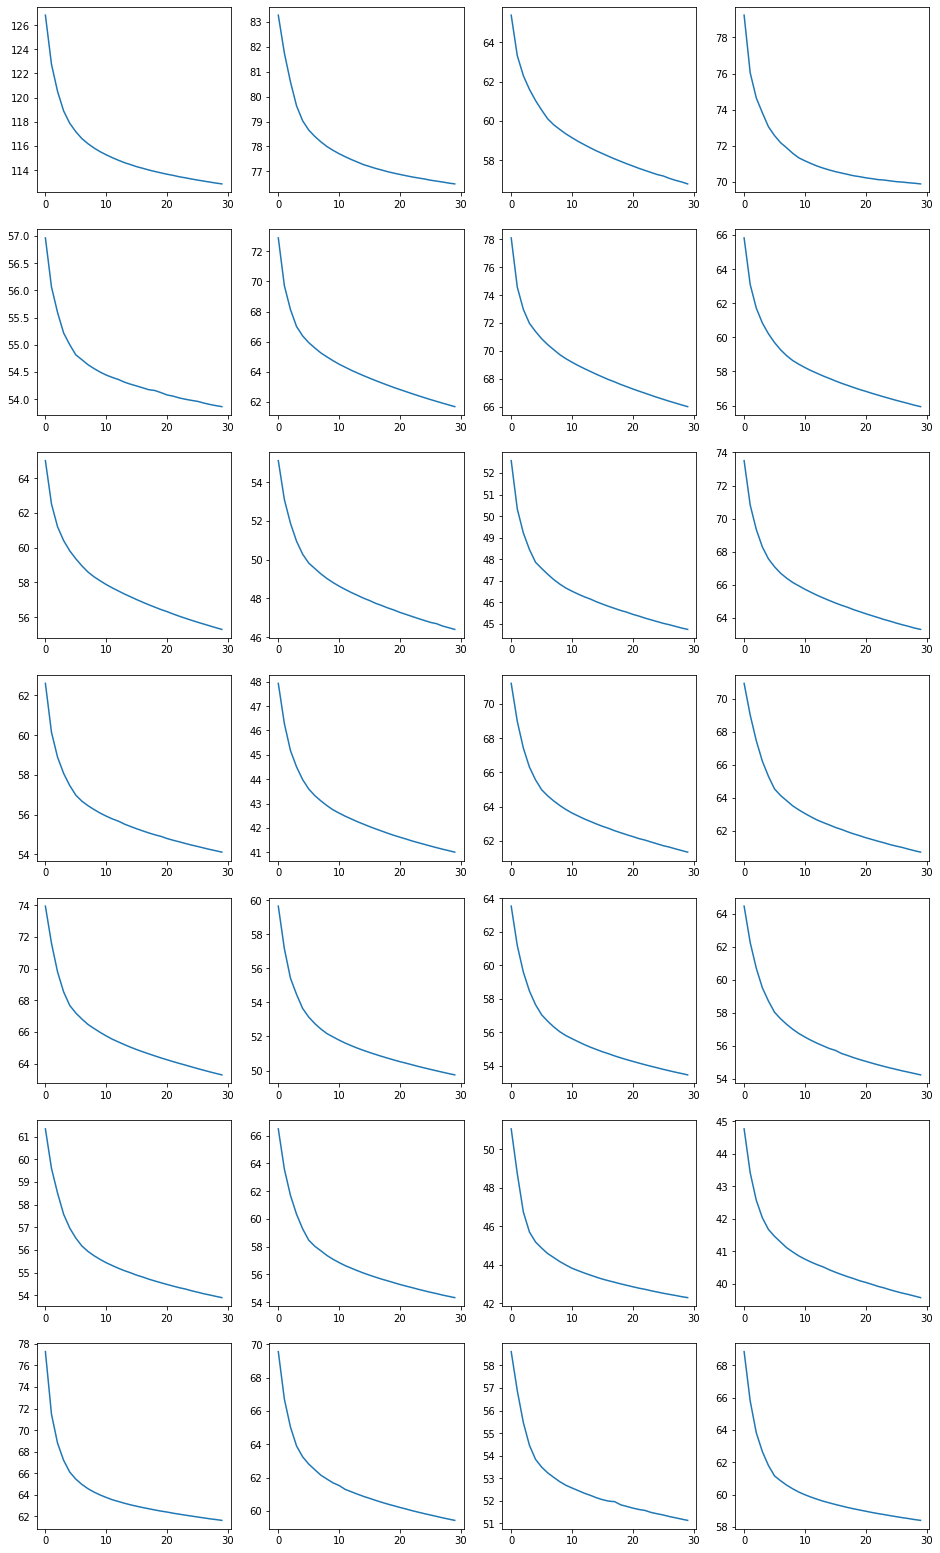

In [18]:
fig, ax = plt.subplots(7, 4, figsize=(16, 28))
for i in range(28):
    a = ax[np.unravel_index(i, (7, 4))]
    a.plot(np.mean(scores[i, 1, ...], axis=0))

In [ ]:
# The relevant criteria is the comparison to the ambient score - load sabes lab data and take the 

In [ ]:
# For a fixed data file, take the 